<a href="https://colab.research.google.com/github/fridymandita/KCBV/blob/main/Image_Classification_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Nearest Neighbor (KNN) 

In [1]:
cd /content

/content


In [2]:
!ls

sample_data


In [3]:
!git clone https://github.com/nholmber/google-colab-cs231n.git

Cloning into 'google-colab-cs231n'...
remote: Enumerating objects: 109, done.
remote: Total 109 (delta 0), reused 0 (delta 0), pack-reused 109
Receiving objects: 100% (109/109), 5.07 MiB | 10.02 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [4]:
%cd google-colab-cs231n/assignment1

/content/google-colab-cs231n/assignment1


In [5]:
!pip install imageio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
%cd cs231n/datasets/
!ls

/content/google-colab-cs231n/assignment1/cs231n/datasets
get_datasets.sh


In [7]:
!more get_datasets.sh

# Get CIFAR10
wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
tar -xzvf cifar-10-python.tar.gz
rm cifar-10-python.tar.gz 


In [8]:
!./get_datasets.sh

--2022-05-27 00:22:32--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  44.8MB/s    in 4.4s    

2022-05-27 00:22:37 (37.3 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [9]:
%cd ../..
!ls

/content/google-colab-cs231n/assignment1
collectSubmission.sh  README.md		    svm.ipynb
cs231n		      requirements.txt	    two_layer_net_colab.ipynb
features.ipynb	      setup_googlecloud.sh  two_layer_net.ipynb
frameworkpython       softmax.ipynb
knn.ipynb	      start_ipython_osx.sh


## Start Building KNN Model

In [10]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Define function for inspecting the source code of a function
import inspect
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import Terminal256Formatter

def pretty_print(func):
  source_code = inspect.getsourcelines(func)[0]
  for line in source_code:
    print(highlight(line.strip('\n'), PythonLexer(), Terminal256Formatter()), end='')
  print('')

In [11]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


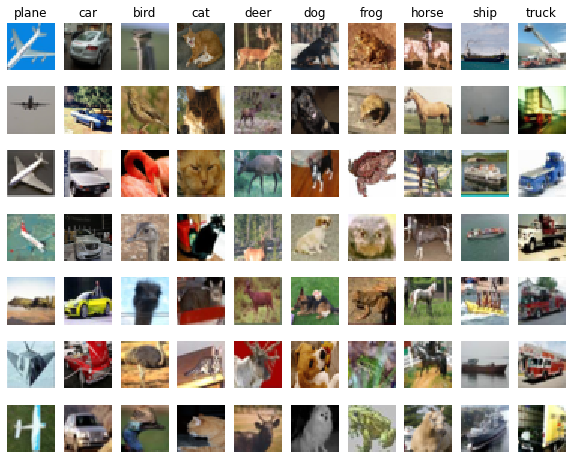

In [12]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [13]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [16]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


#Klasifikasi Gambar dengan KNN

In [17]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.8.0


## Import dataset Fashion MNIST

Panduan ini menggunakan dataset [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) yang memiliki 70,000 gambar hitam putih dalam 10 kategori pakaian. Tiap gambar menunjukan gambar dari satu tipe pakaian dalam resolusi rendah (28 x 28 pixel), seperti yang dapat dilihat disini:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Gambar 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Sampel gambar dari dataset Fashion-MNIST</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

In [18]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [19]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Eksplorasi Data

In [20]:
train_images.shape

(60000, 28, 28)

In [21]:
len(train_labels)

60000

In [22]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [23]:
test_images.shape

(10000, 28, 28)

In [24]:
len(test_labels)

10000

## Melakukan preprocessing terhadap data

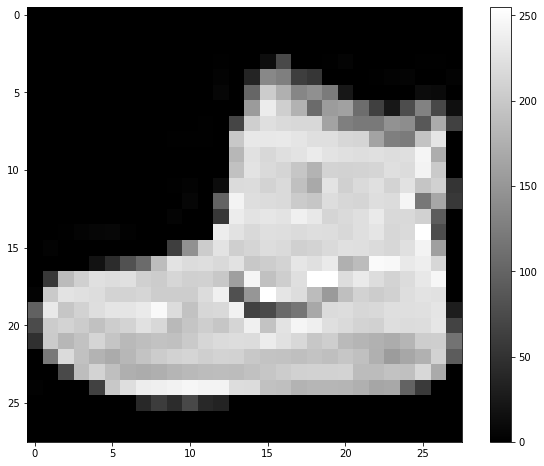

In [25]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [26]:
train_images = train_images / 255.0

test_images = test_images / 255.0

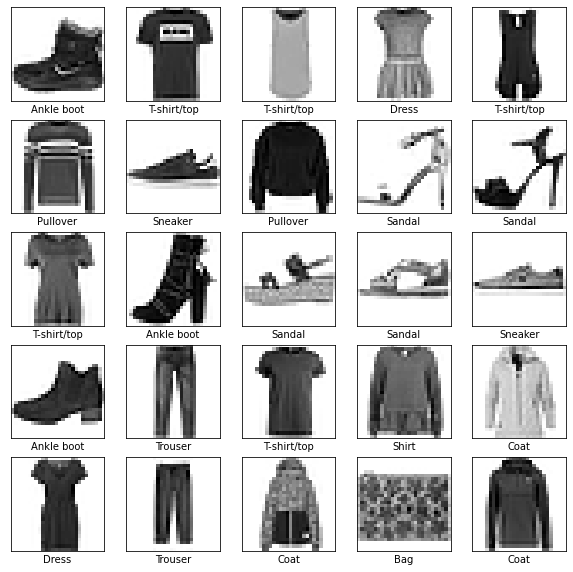

In [27]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## Membangun model

### Pengaturan layer
Komponen utama dari neural network adalah *layer*. Layer mengekstraksi representasi dari data yang masuk ke dalam layer-layer tersebut. Harapannya, representasi tersebut berguna untuk mengatasi permasalahan yang ingin diselesaikan.

Kebanyakan deep learning terdiri atas penggabungan layer-layer sederhana. Kebanyakan layer, seperti `tf.keras.layers.Dense`, memiliki parameter-parameter yang dipelajari ketika proses training dijalankan

In [28]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])


### Proses kompilasi model

In [29]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Proses training dari model


In [30]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4961 - accuracy: 0.8251
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3736 - accuracy: 0.8646
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3366 - accuracy: 0.8766
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3114 - accuracy: 0.8859
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2944 - accuracy: 0.8920
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2811 - accuracy: 0.8957
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2672 - accuracy: 0.9015
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2563 - accuracy: 0.9044
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2470 - accuracy: 0.9082
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.240

## Evaluasi nilai dari akurasi

In [31]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 0.3348 - accuracy: 0.8852 - 556ms/epoch - 2ms/step

Test accuracy: 0.885200023651123


## Membuat prediksi

In [32]:
predictions = model.predict(test_images)

In [33]:
predictions[0]

array([7.9025341e-07, 3.5672580e-09, 9.4166852e-09, 8.1288327e-12,
       2.8033125e-09, 2.4952022e-02, 5.0965645e-09, 1.9054372e-02,
       1.2822952e-07, 9.5599264e-01], dtype=float32)

In [34]:
np.argmax(predictions[0])

9

In [35]:
test_labels[0]

9

In [36]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

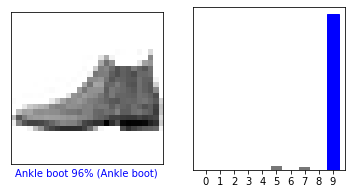

In [37]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

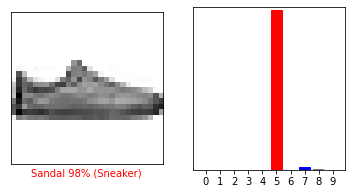

In [38]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

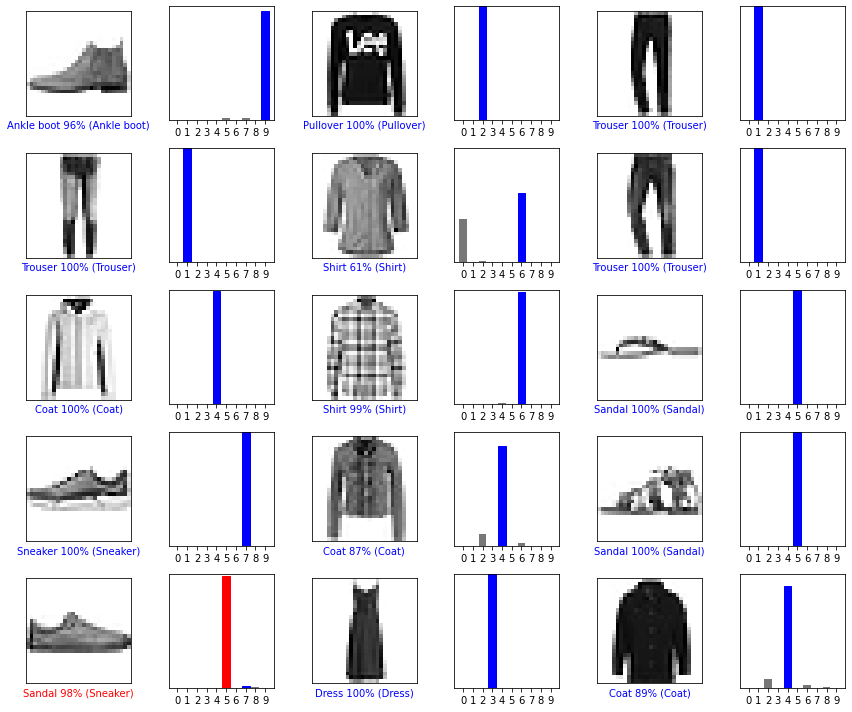

In [39]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

In [40]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

(28, 28)


In [41]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


In [42]:
predictions_single = model.predict(img)

print(predictions_single)

[[1.1554449e-05 2.8895824e-15 9.9985564e-01 5.0777254e-11 7.3510942e-05
  1.7152928e-11 5.9226091e-05 6.7840843e-20 6.1372869e-12 3.1739456e-17]]


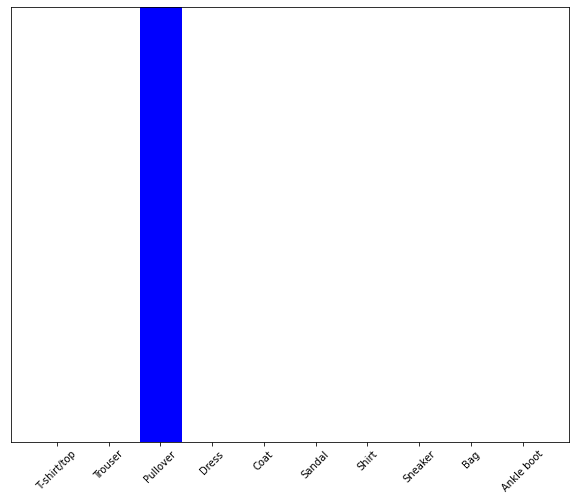

In [43]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [44]:
np.argmax(predictions_single[0])

2